The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(3, 3, 192, 192) (3, 6, 192, 192)


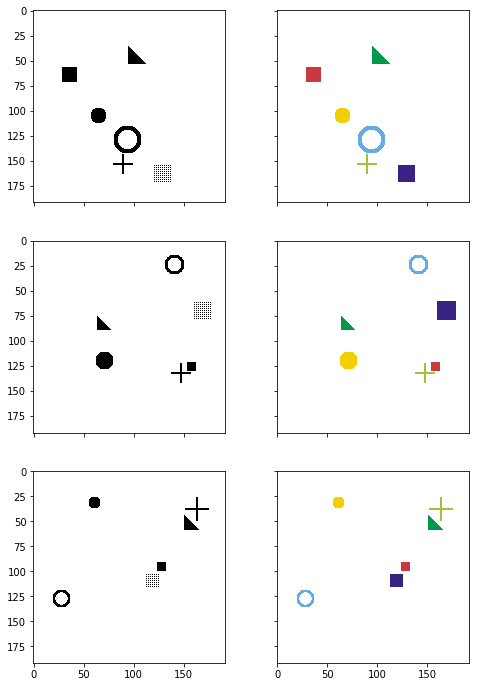

In [23]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import helper
import simulation

# Generate some random images
input_images, target_masks = simulation.generate_random_data(192, 192, count=3)

print(input_images.shape, target_masks.shape)

# Change channel-order and make 3 channels for matplot x (3, 192, 192) -> (192, 192, 3)
# input_images_rgb = [(x.swapaxes(0, 2).swapaxes(0,1) * -255 + 255).astype(np.uint8) for x in input_images
input_images_rgb = [255 - (x.swapaxes(0, 2).swapaxes(0,1)).astype(np.uint8) for x in input_images]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]

# Left: Input image, Right: Target mask
helper.plot_side_by_side([input_images_rgb, target_masks_rgb])

In [24]:
from torchvision import models

base_model = models.resnet18(pretrained=True)

def find_last_layer(layer):
    children = list(layer.children())
    if len(children) == 0:
        return layer
    else:
        return find_last_layer(children[-1])
    
list(base_model.children())

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Asus/.torch\models\resnet18-5c106cde.pth
46827520it [00:07, 6299611.15it/s]


[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

In [25]:
from torch import nn

model_wo_avgpool = nn.Sequential(*list(base_model.children())[:-2])

#OrderedDict(model_wo_avgpool.named_children())

In [27]:
import torch

class FCN(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        layers = list(base_model.children())
        self.layer1 = nn.Sequential(*layers[:5]) # size=(N, 64, x.H/2, x.W/2)
        self.upsample1 = nn.Upsample(scale_factor=4, mode='bilinear')
        self.layer2 = layers[5]  # size=(N, 128, x.H/4, x.W/4)
        self.upsample2 = nn.Upsample(scale_factor=8, mode='bilinear')
        self.layer3 = layers[6]  # size=(N, 256, x.H/8, x.W/8)
        self.upsample3 = nn.Upsample(scale_factor=16, mode='bilinear')
        self.layer4 = layers[7]  # size=(N, 512, x.H/16, x.W/16)
        self.upsample4 = nn.Upsample(scale_factor=32, mode='bilinear')
        
        self.conv1k = nn.Conv2d(64 + 128 + 256 + 512, n_class, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.layer1(x)
        up1 = self.upsample1(x)
        x = self.layer2(x)
        up2 = self.upsample2(x)
        x = self.layer3(x)
        up3 = self.upsample3(x)
        x = self.layer4(x)
        up4 = self.upsample4(x)
        
        merge = torch.cat([up1, up2, up3, up4], dim=1)
        merge = self.conv1k(merge)
        out = self.sigmoid(merge)
        
        return out

fcn_model = FCN(6)

# import torchsummary

#torchsummary.summary(fcn_model, input_size=(3, 224, 224), device='cpu')

In [35]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            batch_size = 10
            epoch_steps = 10
            for i in range(epoch_steps):
                input_images, target_masks = simulation.generate_random_data(192, 192, count=batch_size)
                print(input_images.max(),input_images.min())
                inputs = torch.from_numpy(input_images)
                labels = torch.from_numpy(target_masks)
                inputs = inputs.to(device)
                labels = labels.to(device)                

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / (batch_size * epoch_steps)

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = FCN(6).to(device)

criterion = nn.BCELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
2550


RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same